# 3D MRI Segmentation

In [1]:
# Libaries
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

2025-04-14 21:03:08.574665: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Analysis and Visualization

In [2]:
# Load and preprocess data
data_U = loadmat('data/Brain.mat')
T1_U = data_U['T1']         # MRI slices
label_U = data_U['label']   # Corresponding labels

print("MRI Data Shape:", T1_U.shape)
print("Label Shape:", label_U.shape)

MRI Data Shape: (362, 434, 10)
Label Shape: (362, 434, 10)


In [3]:
print(data_U.keys())
print(T1_U[1:101, 1:101, 1])
print(label_U[1:101, 1:101, 1])

dict_keys(['__header__', '__version__', '__globals__', 'T1', 'label'])
[[  6787.634    6907.175    6907.175  ...  12645.159   13840.573
   13960.114 ]
 [  6429.01     6668.0923   7026.7163 ...  12525.618   13481.949
   14079.655 ]
 [  6548.551    6429.01     6668.0923 ...  15753.234   17426.812
   18861.309 ]
 ...
 [ 10852.039    9776.167    9058.919  ... 288546.6    285318.97
  279939.6   ]
 [ 10493.415    9895.709    9537.085  ... 291176.5    289263.8
  285318.97  ]
 [ 10015.25    10134.791    9895.709  ... 292371.9    291056.94
  288187.97  ]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]]


In [4]:
# Visualize an example slice and ground truth
def visualize_example(data, label, slice_idx):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("MRI Slice")
    plt.imshow(data[:, :, slice_idx], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Ground Truth")
    plt.imshow(label[:, :, slice_idx], cmap='jet')
    plt.axis('off')
    plt.show()

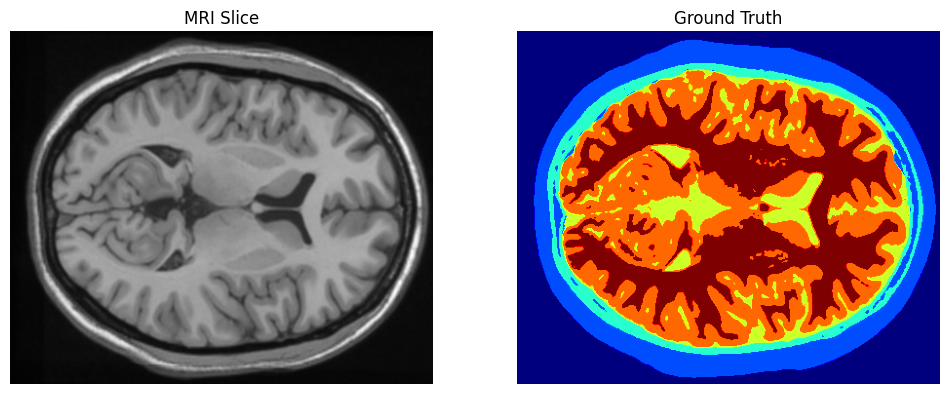

In [5]:
# Visualize slice 5 as an example
visualize_example(T1_U, label_U, slice_idx=5)

## Data Preprocessing

In [6]:
# Constants (TODO: add them to config)
PATCH_SIZE = 64
STRIDE = 32
EXTRACTION_STEP = 10
NUM_CLASSES = 6
BATCH_SIZE = 16
NUM_EPOCHS  = 5

In [7]:
# Transpose to (depth, height, width)
T1_U = np.transpose(T1_U, (2, 0, 1))  # (10, 362, 434)
label_U = np.transpose(label_U, (2, 0, 1))

# Expand to (depth, height, width, channels)
T1 = np.expand_dims(T1_U, axis=-1)
label = np.expand_dims(label_U, axis=-1)

# Normalize input
T1 = T1 / np.max(T1)

## Padding

Add padding to original image so patches cover the whole MRI

In [8]:
def get_padding(volume_shape, patch_size, stride):
    pads = []
    for dim, p, s in zip(volume_shape, patch_size, stride):
        total_covered = ((dim - p) // s + 1) * s
        pad = max(0, total_covered + p - dim)
        pads.append(pad)
    return pads

In [9]:
pad_d, pad_h, pad_w = get_padding(T1.shape[:3], patch_size=(8,128,128), stride=(2,64,64))

# Pad both input and labels
T1_padded = np.pad(T1, ((0, pad_d), (0, pad_h), (0, pad_w), (0, 0)), mode='constant')
label_padded = np.pad(label, ((0, pad_d), (0, pad_h), (0, pad_w), (0, 0)), mode='constant')

## Patches

Extract patches from padded image

In [10]:
# Patch Extraction
def extract_3d_patches(volume, label, patch_size=(8, 128, 128), stride=(2, 64, 64)):
    d, h, w, _ = volume.shape
    patches = []
    label_patches = []

    for z in range(0, d - patch_size[0] + 1, stride[0]):
        for y in range(0, h - patch_size[1] + 1, stride[1]):
            for x in range(0, w - patch_size[2] + 1, stride[2]):
                patch = volume[z:z+patch_size[0], y:y+patch_size[1], x:x+patch_size[2], :]
                label_patch = label[z:z+patch_size[0], y:y+patch_size[1], x:x+patch_size[2], :]
                patches.append(patch)
                label_patches.append(label_patch)

    return np.array(patches), np.array(label_patches)

patches, label_patches = extract_3d_patches(T1, label)
print("Extracted patches:", patches.shape, label_patches.shape)

# --- Train/Test Split ---
train_images, test_images, train_labels, test_labels = train_test_split(
    patches, label_patches, test_size=0.2, random_state=42
)

Extracted patches: (40, 8, 128, 128, 1) (40, 8, 128, 128, 1)


In [11]:
patches, label_patches = extract_3d_patches(
    T1_padded, label_padded,
    patch_size=(8, 128, 128),
    stride=(2, 64, 64)
)

## Metrics and 3D U-NET Architechture

**Metrics**: 
- Dice Coefficient
- IoU

In [12]:
def dice_coef_3d(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(tf.squeeze(y_true, axis=-1), tf.int32)  # (B, D, H, W)
    y_true = tf.one_hot(y_true, depth=NUM_CLASSES)           # (B, D, H, W, C)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = tf.reshape(y_true, [-1, NUM_CLASSES])
    y_pred_f = tf.reshape(y_pred, [-1, NUM_CLASSES])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

    return (2. * intersection + smooth) / (union + smooth)


def iou_3d(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(tf.squeeze(y_true, axis=-1), tf.int32)
    y_true = tf.one_hot(y_true, depth=NUM_CLASSES)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = tf.reshape(y_true, [-1, NUM_CLASSES])
    y_pred_f = tf.reshape(y_pred, [-1, NUM_CLASSES])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    total = tf.reduce_sum(y_true_f + y_pred_f)
    union = total - intersection

    return (intersection + smooth) / (union + smooth)

In [13]:
# 3D U-Net
def unet_3d(input_shape=(8, 128, 128, 1), num_classes=6):
    inputs = Input(input_shape)

    c1 = Conv3D(32, 3, activation='relu', padding='same')(inputs)
    c1 = Conv3D(32, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling3D(pool_size=(2, 2, 2))(c1)

    c2 = Conv3D(64, 3, activation='relu', padding='same')(p1)
    c2 = Conv3D(64, 3, activation='relu', padding='same')(c2)

    u3 = Conv3DTranspose(32, 2, strides=(2, 2, 2), padding='same')(c2)
    u3 = concatenate([u3, c1])
    c3 = Conv3D(32, 3, activation='relu', padding='same')(u3)
    c3 = Conv3D(32, 3, activation='relu', padding='same')(c3)

    outputs = Conv3D(num_classes, 1, activation='softmax')(c3)
    model = Model(inputs, outputs)
    return model

In [14]:
model = unet_3d()
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', dice_coef_3d, iou_3d]
)

In [15]:
# Train Model
model.fit(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    batch_size=2,
    epochs=30
)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 163s 10s/step - accuracy: 0.2533 - dice_coef_3d: 0.2277 - iou_3d: 0.1305 - loss: 1.6167 - val_accuracy: 0.3614 - val_dice_coef_3d: 0.3320 - val_iou_3d: 0.1996 - val_loss: 1.2779
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 161s 10s/step - accuracy: 0.3647 - dice_coef_3d: 0.3359 - iou_3d: 0.2026 - loss: 1.2892 - val_accuracy: 0.4038 - val_dice_coef_3d: 0.3703 - val_iou_3d: 0.2278 - val_loss: 1.1665
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 143s 9s/step - accuracy: 0.4849 - dice_coef_3d: 0.3843 - iou_3d: 0.2390 - loss: 1.1383 - val_accuracy: 0.7386 - val_dice_coef_3d: 0.4989 - val_iou_3d: 0.3324 - val_loss: 0.8199
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 136s 8s/step - accuracy: 0.6920 - dice_coef_3d: 0.5466 - iou_3d: 0.3779 - loss: 0.8195 - val_accuracy: 0.7004 - val_dice_coef_3d: 0.6177 - val_iou_3d: 0.4470 - val_loss: 0.7203
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 131s 8s/step - accuracy: 0.7385 - dice_coef_3d: 0.6111 - iou_3d: 0.4418 - loss: 0.7223 - val_accurac

In [17]:
# Evaluate Model
loss, acc, dice, iou_score = model.evaluate(test_images, test_labels)
print(f"Loss: {loss}, Accuracy: {acc}, Dice: {dice}, IoU: {iou_score}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.9444 - dice_coef_3d: 0.9118 - iou_3d: 0.8380 - loss: 0.1525
Loss: 0.1524999588727951, Accuracy: 0.9444036483764648, Dice: 0.9118378758430481, IoU: 0.8379615545272827


## Predictions

In [18]:
def reconstruct_volume(patches, original_shape, patch_size=(8, 128, 128), stride=(2, 64, 64)):
    D, H, W = original_shape
    volume = np.zeros((D, H, W))
    count = np.zeros((D, H, W))

    patch_idx = 0
    d_steps = range(0, D - patch_size[0] + 1, stride[0])
    h_steps = range(0, H - patch_size[1] + 1, stride[1])
    w_steps = range(0, W - patch_size[2] + 1, stride[2])

    for z in d_steps:
        for y in h_steps:
            for x in w_steps:
                patch = patches[patch_idx]
                volume[z:z+patch_size[0], y:y+patch_size[1], x:x+patch_size[2]] += patch
                count[z:z+patch_size[0], y:y+patch_size[1], x:x+patch_size[2]] += 1
                patch_idx += 1

    # Prevent divide-by-zero
    count[count == 0] = 1
    return volume / count

In [19]:
predictions = model.predict(patches)
pred_mask = np.argmax(predictions, axis=-1) # Shape: (N_patches, D, H, W)

print(pred_mask.shape)

3/3 ━━━━━━━━━━━━━━━━━━━━ 53s 16s/step
(90, 8, 128, 128)


In [21]:
reconstructed_padded = reconstruct_volume(
    patches=pred_mask,
    original_shape=T1_padded.shape[:3],
    patch_size=(8, 128, 128),
    stride=(2, 64, 64)
)

# Crop back to original shape
reconstructed = reconstructed_padded[:T1.shape[0], :T1.shape[1], :T1.shape[2]]

In [24]:
def plot_all_slices(volume, title='Slice', cmap='gray'):
    plt.imshow(volume[0], cmap=cmap)
    plt.title(f"{title}")
    plt.axis('off')
    
    plt.show()

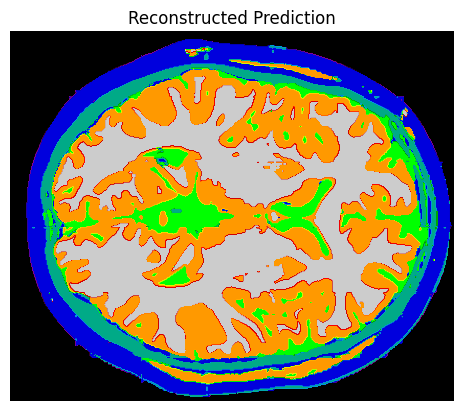

In [25]:
plot_all_slices(reconstructed.astype(int), title="Reconstructed Prediction", cmap="nipy_spectral")